***
# Imports

In [136]:
import numpy as np
import random
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'

In [2]:
# hera stuff
import hera_cal as hc
import pyuvdata
import aipy
import uvtools

***
# Data

Load the data from disk and extract a list of redundant baselines from the associated calfits file.

In [3]:
data_directory = '../zen_data/'
miriad_path = data_directory + 'zen.2458098.58037.xx.HH.uv'

uvd = pyuvdata.UVData()
uvd.read_miriad(miriad_path)

# get the redundancies for that data
aa = hc.utils.get_aa_from_uv(uvd)
info = hc.omni.aa_to_info(aa)
hc.omni.filter_reds()
red_bls = np.array(info.get_reds())

# gains for same data 
calfits_path = data_directory + 'zen.2458098.58037.xx.HH.uv.abs.calfits'
gains, flags = hc.io.load_cal(calfits_path)

In [223]:
def ants_good(bl, gain_keys):
    """Returns True if BOTH antennas are in gain_keys.
    Parameters
    ----------
    bl : tuple of ints
    gain_keys : list of tuples of (int, _)
    
    Returns
    -------
    bool
    """
    ants = [a[0] for a in gain_keys] 
    if bl[0] in ants and bl[1] in ants:
        return True
    else:
        return False

def get_bad_bls_indicies(red_bls, gain_keys):
    """Find the indicies in red_bls that corresponds to groups where every element is made of at least one bad antenna.
    Parameters
    ----------
    red_bls : an array of lists of redundant baselines
    gain_keys : list of tuples of (int, _)
    
    Returns
    -------
    list of ints
    """
    x = 0 # the number of bad baselines in a group
    bad_indices = []
    
    for idx, blg in enumerate(red_bls):# for every baseline group (blg) in red_bls     
        for bl in blg: # for every baseline in a group
            if ants_good(bl, gain_keys) == True:
                pass # if both the antennas in a baseline are good, do nothing
            else:
                x += 1# if either antenna is bad, increment a counter
                
        if len(blg) == x: # if the number of baselines in a group is equal to the number of bad baselines, flag.
            bad_indices.append(idx)
        x = 0
    return bad_indices

def get_good_red_bls(red_bls, gain_keys):
    """Eliminate baseline groups that ONLY contain bad antennas."""
    return np.delete(red_bls, get_bad_bls_indicies(red_bls, gain_keys))

def get_bls(example_bl, red_bls):
    """Get a list of baselines from bls that have the direction and spearation of example_bl.
    Parameters
    ----------
    example_bl: tuple of ints
    red_bls : an array of lists
    
    Returns
    -------
    list of tuples
    """
    return [bl for bl in red_bls if example_bl in bl][0]

def get_all_example_bls(red_bls):
    """Get all the example baselines from a list of redundant baseline groups,
    where an example baseline is the baseline with the lowest antenna numbers.
    Parameters
    ----------
    red_bls : an array of lists
    
    Returns
    -------
    list of tuples
    """
    return [x[0] for x in sorted(red_bls)]

def get_two_random_example_bls(red_bls):
    return random.sample(red_bls, 2)

def get_data_for_bls(bls, gain_keys):
    return {bl: uvd.get_data(bl) for bl in bls if ants_good(bl, gain_keys)}

def get_random_key(data_dict_keys):
    return random.sample(data_dict_keys, 1)[0]

def get_data_from_key(data_dict, key):
    
    return data_dict[key[0], key[1]]

***
# Working with the above functions and data

Pare down the array of redundant baseline lists into an array where each list has at least one good antenna.

In [186]:
good_redundant_baselines = get_good_red_bls(red_bls, gains.keys()) 

Find the example baseline for each group of redundant baselines.

In [187]:
example_bls = get_all_example_bls(good_redundant_baselines)

Randomly select two different example baselines

In [188]:
rnd_examples = get_two_random_example_bls(example_bls)

In [189]:
print(rnd_examples)
sep_A_bl_ex = rnd_examples[0]; sep_B_bl_ex = rnd_examples[1]; 

[(0, 122), (0, 55)]


Get the baselines that are represented by those examples

In [190]:
sep_A_bls = get_bls(sep_A_bl_ex, good_redundant_baselines)
sep_B_bls = get_bls(sep_B_bl_ex, good_redundant_baselines)

Get the data for those baselines.

In [227]:
sep_A_data_dict = get_data_for_bls(sep_A_bls, gains.keys())
sep_B_data_dict = get_data_for_bls(sep_B_bls, gains.keys())

Randomly select a baseline key and get its data

In [245]:
sep_A_rnd_key = get_random_key(sep_A_data_dict.keys())
sep_B_rnd_key = get_random_key(sep_A_data_dict.keys())

sep_A_rnd_data = get_data_from_key(sep_A_data_dict, sep_A_rnd_key)
sep_B_rnd_data = get_data_from_key(sep_A_data_dict, sep_B_rnd_key)

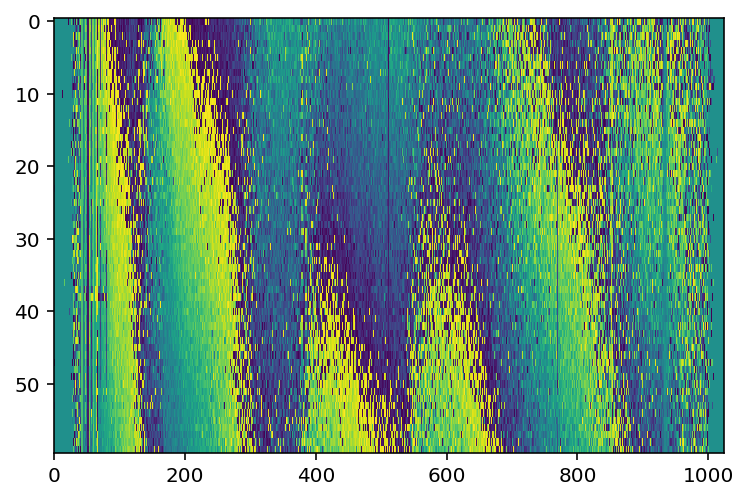

In [254]:
plt.imshow(np.angle(sep_A_rnd_data), aspect = 'auto')
plt.show()

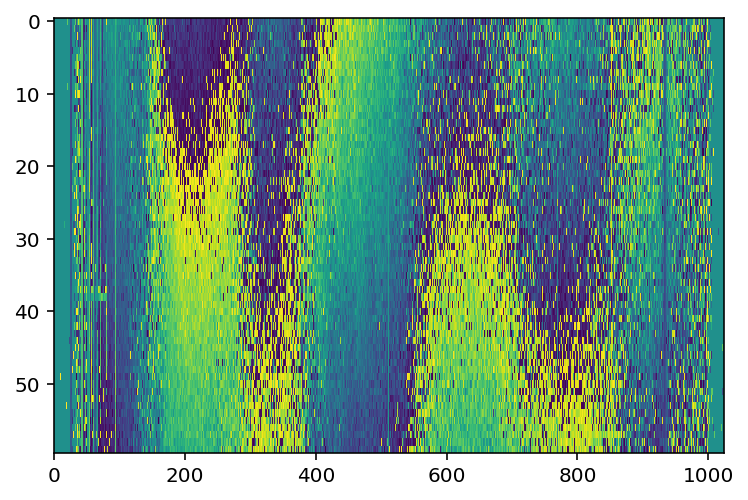

In [255]:
plt.imshow(np.angle(sep_B_rnd_data), aspect = 'auto')
plt.show()